In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

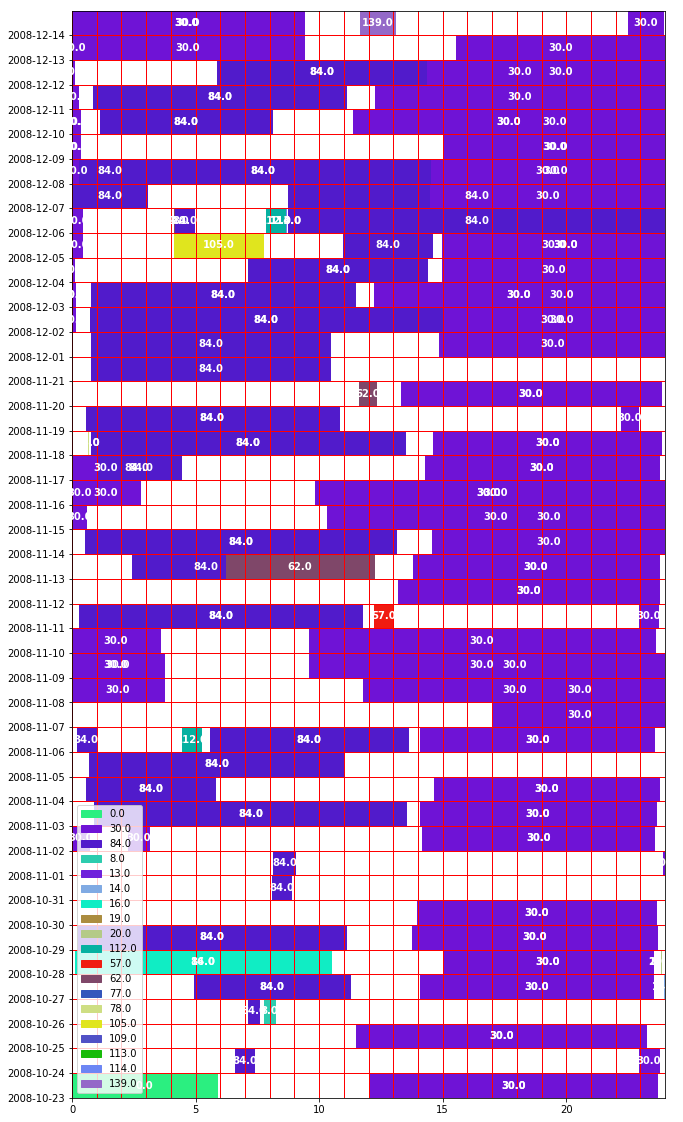

In [2]:
from datetime import datetime, timedelta
import random
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import math 
import os
import errno
import matplotlib.patches as patches
from copy import deepcopy
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.patches import Ellipse, Circle
import operator
import pdb
from geopy.geocoders import Nominatim

pd.options.mode.chained_assignment = None
time_format = '%H:%M:%S'

#------------------------------------------------------------------------------------
def populate_usr_trejec_df(file_src):
    global usr_trejec_df
    
    usr_trejec_df = usr_trejec_df.iloc[0:0]
    usr_trejec_df['TrajId'] = 0
    usr_trejec_df['File'] = 0
    usr_trejec_df['StrLat'] = 0.0
    usr_trejec_df['StrLon'] = 0.0
    usr_trejec_df['StartDatetime'] = 0
    usr_trejec_df['EndLat'] = 0.0
    usr_trejec_df['EndLon'] = 0.0
    usr_trejec_df['EndDatetime'] = 0
    usr_trejec_df['Dist(km)'] = 0.0
    usr_trejec_df['Time(hr)'] = 0.0
    usr_trejec_df['Spd(km/hr)'] = 0.0

    
    for dirname, dirnames, filenames in os.walk(file_src):
        i = 0
        #import pdb; pdb.set_trace()
        for filename in filenames:
            if  filename.endswith('plt'):

                gpsfile = os.path.join(dirname, filename)
                log = open(gpsfile, 'r')
                points = log.readlines()[6:] # first 6 lines are useless
                pointNum = len(points)
                
                first_point = points[0].rstrip().split(',')
                last_point = points[len(points)-1].rstrip().split(',')
                start_time = first_point[6]
                end_time = last_point[6]
                trj_time = (datetime.strptime(end_time, time_format) - datetime.strptime(start_time, time_format)).seconds/3600

                #import pdb; pdb.set_trace()
                usr_trejec_df.loc[i, 'File'] = filename
                usr_trejec_df.loc[i, 'StrLat'] = float(first_point[0])
                usr_trejec_df.loc[i ,'StrLon'] = float(first_point[1])
                usr_trejec_df.loc[i, 'EndLat'] = float(last_point[0])
                usr_trejec_df.loc[i, 'EndLon'] = float(last_point[1])
                
                usr_trejec_df.loc[i, 'Dist(km)'] =  meters(float(first_point[0]), float(first_point[1]), 
                                                         float(last_point[0]), float(last_point[1])) / 1000
                usr_trejec_df.loc[i, 'Time(hr)'] = trj_time
                usr_trejec_df.loc[i, 'Spd(km/hr)'] = ((usr_trejec_df.loc[i, 'Dist(km)']) / 
                                                        (usr_trejec_df.loc[i, 'Time(hr)']))
                usr_trejec_df.loc[i, 'StartDatetime'] = first_point[5] + " " + first_point[6]
                usr_trejec_df.loc[i, 'EndDatetime'] = last_point[5] + " " + last_point[6]
                i+=1
    
    usr_trejec_df = usr_trejec_df.sort_values(['File'])
    usr_trejec_df = usr_trejec_df.reset_index(drop=True)
    usr_trejec_df['TrajId'] = usr_trejec_df.index
#-------------------------------
def prepare_dfs():
    global cluster_hourly_df    
    
    #create cluster_hourly_df columns
    for i in range(0, 24):
        cluster_hourly_df['Date'] = 0
        cluster_hourly_df['StateId'] = 0
        cluster_hourly_df['AvgLat'] = 0
        cluster_hourly_df['AvgLon'] = 0
        cluster_hourly_df[i] = 0
        
#------------------------------------------------------------------------------------
#Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):  
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));
    d = R * c
    return d * 1000 # meters


#------------------------------------------------------------------------------------
def assign_staypts():
    global staypts_df
    
    staypts_df = staypts_df.iloc[0:0]
    staypts_df['Timestamp'] = 0
    staypts_df['StayptId'] = 0
    staypts_df['StayMeanLat'] = 0.0
    staypts_df['StayMeanLon'] = 0.0
    staypts_df['StateId'] = 0
    staypts_df['StateMeanLat'] = 0.0
    staypts_df['StateMeanLon'] = 0.0
    
    i=0
    j=0
    while i <len(usr_trejec_df):
        
        staypts_df.loc[j, 'StayptId'] = j
        staypts_df.loc[j, 'StayMeanLat'] = usr_trejec_df.loc[i, 'StrLat']
        staypts_df.loc[j, 'StayMeanLon'] = usr_trejec_df.loc[i, 'StrLon']
        staypts_df.loc[j, 'Timestamp'] = usr_trejec_df.loc[i, 'StartDatetime']
        
        staypts_df.loc[j+1, 'StayptId'] = j+1
        staypts_df.loc[j+1, 'StayMeanLat'] = usr_trejec_df.loc[i, 'EndLat']
        staypts_df.loc[j+1, 'StayMeanLon'] = usr_trejec_df.loc[i, 'EndLon']
        staypts_df.loc[j+1, 'Timestamp'] = usr_trejec_df.loc[i, 'EndDatetime']
        i+=1
        j+=2

#-------------form states-----------------------------------------------------------------------
def form_states():
    global staypts_df
    global curr_hr_staypts_df
    
    #update states in final staypoints
    #copy staypoint data as state data
    staypts_df['StateId'] = staypts_df['StayptId']
    staypts_df['StateMeanLat'] = staypts_df['StayMeanLat']
    staypts_df['StateMeanLon'] = staypts_df['StayMeanLon']
    
    #this fucntion groups the staypoints together to from different days 
    #Copy the stay points dataframe into another dataframe and remove duplicates
    staypts_df1 = staypts_df[['StateId', 'StateMeanLat', 'StateMeanLon']].copy()
    staypts_df1 = staypts_df1.drop_duplicates(subset=['StateId', 'StateMeanLat', 'StateMeanLon'])

    staypts_df1 = staypts_df1.sort_values(['StateMeanLat', 'StateMeanLon'])
    staypts_df1 = staypts_df1.reset_index(drop=True)
    
    row = 1

    for i in range(0, len(staypts_df1)-1):
        #import pdb; pdb.set_trace()
        for j in range(i+1, len(staypts_df1)):
            
            chk_cluster = staypts_df1['StateId'][i]
            chk_clulat = staypts_df1['StateMeanLat'][i]
            chk_clulon = staypts_df1['StateMeanLon'][i]
            curr_cluster = staypts_df1['StateId'][j]
            curr_clulat = staypts_df1['StateMeanLat'][j]
            curr_clulon = staypts_df1['StateMeanLon'][j]
        
            if meters(chk_clulat, chk_clulon, curr_clulat, curr_clulon)<= state_d_thrhld:
                #before adding this point to the ith state, 
                #   calculate new mean with jth point,
                #   if the new mean is still keeping all the states with id(i) than add jth to the state
                #   else not
                
                add_state = "Yes"
                #form the existing lat and lon array
                array_lat = staypts_df['StateMeanLat'].loc[staypts_df['StateId'] == chk_cluster].values
                array_lon = staypts_df['StateMeanLon'].loc[staypts_df['StateId'] == chk_cluster].values
                #add the new lat and lon values to the array
                new_lats = staypts_df['StateMeanLat'].loc[staypts_df['StateId'] == curr_cluster].values
                new_lons = staypts_df['StateMeanLon'].loc[staypts_df['StateId'] == curr_cluster].values
                
                array_lat= np.append(array_lat, new_lats)
                array_lon= np.append(array_lon, new_lons)
                #cal new means
                new_lat_mean = np.mean(array_lat)
                new_lon_mean = np.mean(array_lon)
                
                for k in range(0, len(array_lat)):
                    if meters(array_lat[k], array_lon[k], new_lat_mean, new_lon_mean) > state_d_thrhld:
                        
                        add_state = "No"
                        
                if add_state == "Yes":   
                    staypts_df1.loc[ (staypts_df1['StateId']==curr_cluster), 'StateId'] = chk_cluster
                    staypts_df1.loc[ (staypts_df1['StateId']==chk_cluster), 'StateMeanLat'] = new_lat_mean
                    staypts_df1.loc[ (staypts_df1['StateId']==chk_cluster), 'StateMeanLon'] = new_lon_mean
                    
                    staypts_df.loc[ (staypts_df['StateId']==curr_cluster), 'StateId'] = chk_cluster
                    staypts_df.loc[ (staypts_df['StateId']==chk_cluster), 'StateMeanLat'] = new_lat_mean
                    staypts_df.loc[ (staypts_df['StateId']==chk_cluster), 'StateMeanLon'] = new_lon_mean
#             else:
#                 break
                
    staypts_df.Timestamp = pd.to_datetime(staypts_df.Timestamp)
    #save staypoint file
    staypts_df.to_csv(dest_file_staypoints, sep='\t', encoding='utf-8')            

#------------------------------------------------------------------------------------------------
def cal_start_end_staypts():
    global start_end_staypts_df
    
    start_end_staypts_df['Date'] = 0
    start_end_staypts_df['StateId'] = 0
    start_end_staypts_df['StateMeanLat'] = 0
    start_end_staypts_df['StateMeanLon'] = 0
    start_end_staypts_df['StartTimestamp'] = 0
    start_end_staypts_df['EndTimestamp'] = 0
    
    start_end_staypts_df['StartTimestamp'] = pd.to_datetime(start_end_staypts_df['StartTimestamp'])
    start_end_staypts_df['EndTimestamp'] = pd.to_datetime(start_end_staypts_df['EndTimestamp'])
    
    j = 0
    for i in range(len(staypts_df)-1):
        if i == 0:
            date = staypts_df.loc[i, 'Timestamp'].date()
            state = staypts_df.loc[i, 'StateId']
            statemeanlat = staypts_df.loc[i, 'StateMeanLat']
            statemeanlon = staypts_df.loc[i, 'StateMeanLon']
            start = (staypts_df.loc[i, 'Timestamp'] - 
                     timedelta(hours=staypts_df.loc[i, 'Timestamp'].hour) -
                     timedelta(minutes=staypts_df.loc[i, 'Timestamp'].minute)
                    )
            end = staypts_df.loc[i, 'Timestamp']
            
            start_end_staypts_df.loc[j, 'Date'] = date
            start_end_staypts_df.loc[j, 'StateId'] = state
            start_end_staypts_df.loc[j, 'StateMeanLat'] = statemeanlat
            start_end_staypts_df.loc[j, 'StateMeanLon'] = statemeanlon
            start_end_staypts_df.loc[j, 'StartTimestamp'] = start
            start_end_staypts_df.loc[j, 'EndTimestamp'] = end
            j+=1
            
        if i%2 != 0:
            
            end1_trj_time = staypts_df.loc[i, 'Timestamp']
            end1_trj_lat = staypts_df.loc[i, 'StayMeanLat']
            end1_trj_lon = staypts_df.loc[i, 'StayMeanLon']
            str2_trj_time = staypts_df.loc[i+1, 'Timestamp']
            str2_trj_lat = staypts_df.loc[i+1, 'StayMeanLat']
            str2_trj_lon = staypts_df.loc[i+1, 'StayMeanLon']
            
            
            dist = meters(end1_trj_lat, end1_trj_lon, str2_trj_lat, str2_trj_lon)
            time = (str2_trj_time - end1_trj_time).seconds / 60
            avg_speed = dist/time
            
            delta_t = min(state_d_thrhld, dist)/avg_speed
            
            end1_trj_time = end1_trj_time + timedelta(minutes=delta_t)
            str2_trj_time = str2_trj_time - timedelta(minutes=delta_t)
            
            #staypoint 1
            date = staypts_df.loc[i, 'Timestamp'].date()
            state = staypts_df.loc[i, 'StateId']
            statemeanlat = staypts_df.loc[i, 'StateMeanLat']
            statemeanlon = staypts_df.loc[i, 'StateMeanLon']
            start = staypts_df.loc[i, 'Timestamp']
            end = end1_trj_time
            
            start_end_staypts_df.loc[j, 'Date'] = date
            start_end_staypts_df.loc[j, 'StateId'] = state
            start_end_staypts_df.loc[j, 'StateMeanLat'] = statemeanlat
            start_end_staypts_df.loc[j, 'StateMeanLon'] = statemeanlon
            start_end_staypts_df.loc[j, 'StartTimestamp'] = start
            start_end_staypts_df.loc[j, 'EndTimestamp'] = end
            j+=1
            
            #staypoint 2
            date = staypts_df.loc[i+1, 'Timestamp'].date()
            state = staypts_df.loc[i+1, 'StateId']
            statemeanlat = staypts_df.loc[i+1, 'StateMeanLat']
            statemeanlon = staypts_df.loc[i+1, 'StateMeanLon']
            start = str2_trj_time
            end = staypts_df.loc[i+1, 'Timestamp']
            
            start_end_staypts_df.loc[j, 'Date'] = date
            start_end_staypts_df.loc[j, 'StateId'] = state
            start_end_staypts_df.loc[j, 'StateMeanLat'] = statemeanlat
            start_end_staypts_df.loc[j, 'StateMeanLon'] = statemeanlon
            start_end_staypts_df.loc[j, 'StartTimestamp'] = start
            start_end_staypts_df.loc[j, 'EndTimestamp'] = end
            j+=1
    
    #save start end staypoints file
    start_end_staypts_df.to_csv(dest_file_hourly_weights, sep='\t', encoding='utf-8')
            
#------------------------------------------------------------------------------------------------
def visualize_stay_points():
    global staypts_df

    #create a color dictionary for each cluster for the plot
    dicts = {}
    clu_list = []
    clu_list = start_end_staypts_df['StateId'].unique()
    r = lambda: random.randint(0,255)
    #olors = sns.color_palette("Paired", len(clu_list))
    
    for i in range(0, len(clu_list)):
        #icts[clu_list[i]] = (colors[i])
        dicts[clu_list[i]] = ('#%02X%02X%02X' % (r(),r(),r()))
        
    #create a new graph where we will later add rectangles for each hour:cluster
    fig2 = plt.figure(figsize=(20,20))
    ax1 = fig2.add_subplot(111, aspect='equal')

    #get all the dates for y axis
    date_list = start_end_staypts_df['Date'].unique()
    y = range(0, len(date_list))
    def_yticks = date_list
    plt.yticks(y, def_yticks)
    
    #set the x axis limit from 0-24 hours of a day, y axis with dates
    limsx = (0, 24)
    limsy = (0, len(date_list))

    date_counter = 0
    last_date = start_end_staypts_df['Date'][0]
    
    #drawing verical lines for each hour
    for i in range(0, 24):
        ax1.axvline(x= i, linewidth=1, color='r')

    for i in range(0, len(start_end_staypts_df)):
        #import pdb; pdb.set_trace()
        
        if (last_date != start_end_staypts_df['Date'][i]):
            date_counter = date_counter + 1
            last_date = start_end_staypts_df['Date'][i]
            ax1.axhline(y= date_counter, linewidth=1, color='r')
        
        #if the trajectory is going to next day
        if (start_end_staypts_df['StartTimestamp'][i].date() !=
           start_end_staypts_df['EndTimestamp'][i].date()):
            #day 1 rectangle
            a = (start_end_staypts_df['StartTimestamp'][i].hour + 
             start_end_staypts_df['StartTimestamp'][i].minute/60)
            b = 24
            width = b - a
            height = 1
            col_id = dicts.get(start_end_staypts_df['StateId'][i])
            ax1.add_patch(patches.Rectangle((a, date_counter), width, height, 
                                            color=col_id, label=start_end_staypts_df['StateId'][i]))
            ax1.annotate(start_end_staypts_df['StateId'][i], (a + width/2, height/2 + date_counter), 
                     color='w', weight='bold', fontsize=10, ha='center', va='center')
            
            #day 2 rectangle
            a = 0
            b = (start_end_staypts_df['EndTimestamp'][i].hour + 
             start_end_staypts_df['EndTimestamp'][i].minute/60)
            width = b - a
            height = 1
            col_id = dicts.get(start_end_staypts_df['StateId'][i])
            ax1.add_patch(patches.Rectangle((a, date_counter+1), width, height, 
                                            color=col_id, label=start_end_staypts_df['StateId'][i]))
            ax1.annotate(start_end_staypts_df['StateId'][i], (a + width/2, height/2 + date_counter+1), 
                     color='w', weight='bold', fontsize=10, ha='center', va='center')
            
        if (start_end_staypts_df['StartTimestamp'][i].date() ==
           start_end_staypts_df['EndTimestamp'][i].date()):    
            a = (start_end_staypts_df['StartTimestamp'][i].hour + 
                 start_end_staypts_df['StartTimestamp'][i].minute/60)
            b = (start_end_staypts_df['EndTimestamp'][i].hour +
                start_end_staypts_df['EndTimestamp'][i].minute/60)
            width = b - a
            height = 1
            col_id = dicts.get(start_end_staypts_df['StateId'][i])
            ax1.add_patch(patches.Rectangle((a, date_counter), width, height, 
                                            color=col_id, label=start_end_staypts_df['StateId'][i]))
            ax1.annotate(start_end_staypts_df['StateId'][i], (a + width/2, height/2 + date_counter), 
                         color='w', weight='bold', fontsize=10, ha='center', va='center')
            
        
    
    handles, labels = ax1.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    plt.legend(handle_list, label_list)

    plt.xlim(limsx)
    plt.ylim(limsy)
    plt.show()

#------------------------------------------ S T A R T -----------------------------------------------
#global dataframes used
#user raw trajectory dataframe
usr_trejec_df = pd.DataFrame()
#all staypoints
staypts_df = pd.DataFrame()
#final markov chains
start_end_staypts_df = pd.DataFrame()

clus_dict = {}
co_loc = {}
pred_loc = {}
lat_array = []
lon_array = []
global_count = 0

#---------------------------------------------------------------------------------------------------------------------
#--------------------------------------CHANGE HERE FOR USER AND DATE RANGE--------------------------------------------
#---------------------------------------------------------------------------------------------------------------------

#Edit user name, and path locations for source and destination files
user = "001"
state_d_thrhld = 200
staypts_d_thrhld = 200
staypts_t_thrhld = 20

#destination paths
usr_directory = "/home/shashank/Documents/location/code/several tests/test 6/results/User " + user
usr_hrly_wght_directory = "/home/shashank/Documents/location/code/several tests/test 6/results/User " + user + "/hourlyweights"
usr_sty_pts_directory = "/home/shashank/Documents/location/code/several tests/test 6/results/User " + user + "/staypoints"

if not os.path.exists(usr_directory):
    os.makedirs(usr_directory)
if not os.path.exists(usr_hrly_wght_directory):
    os.makedirs(usr_hrly_wght_directory)
if not os.path.exists(usr_sty_pts_directory):
    os.makedirs(usr_sty_pts_directory)  

#destination file names
dest_file_staypoints = usr_sty_pts_directory + "/staypoints.csv"
dest_file_hourly_weights = usr_hrly_wght_directory + "/hourlyweights.csv"

#remove if the file already exists
try:
    os.remove(dest_file_staypoints)
    os.remove(dest_file_hourly_weights)
except OSError:
    pass

#source paths
file_source_raw = "/home/shashank/Documents/location/Geolife Trajectories 1.3/Data/" + user + "/Trajectory/" 

#---------------------------------------------------------------------------------------------------------------------
#--------------------------------------CHANGE HERE FOR USER AND DATE RANGE--------------------------------------------
#---------------------------------------------------------------------------------------------------------------------

#read test user trajectory file. In real scenerio, this will be the GPS read data
populate_usr_trejec_df(file_source_raw)

#assign start and endpoints as staypoints
assign_staypts()

#form states from staypoints(grouping staypoints based on distance)
form_states()

#add times between trejectories based on avg speed
cal_start_end_staypts()

#visualize the hourly distribution
visualize_stay_points()


In [3]:
start_end_staypts_dfc


""
